# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
#### Faisal Irzal

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

Rotterdam is well-known as a major logistic and economic center and has Europe's largest seaport. It is the 2nd largest city and minicipality in The Netherlands. With a population of more than 650,000 living in an area of 324 km<sup>2</sup>, Rotterdam is known for its university, riverside setting, lively culture life, maritime heritage and modern culture, and not to forget, it is a home to over 180 nationalities [1].

Having a plan to look for real estate in Rotterdam, I decided to analyse Rotterdam for this project. I am particularly interested in having the knowledge of where the best place to live in this city. In my opinion, the best place to live can be defined as the area which has:
1. short distance to important public places, i.e. supermarket, hospitals, and public transport
2. lower population density; area with high population density is perceived low safety and environmental quality
3. affordable housing price; price should be affordable for young families to get mortgage to finance the house
4. more modern houses; assume that old houses might require renovation hence increase the cost

I understood that the criteria above may not reflect bigger population. However, in my opinion, the above categories could fit the stakeholders who just start their professional career. 

This assignment will showcase data science tools and knowledge I have gained to generate a few most promising neighborhoods based on the above criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of the problem, factors that may influence stakeholder's decision are:
* location
* population density 
* average house price
* age of the house

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

The following data sources will be neede to extract and generate the required information:
* list of neighborhoods in Rotterdam, its population density and the average house price can be obtained from PDOK, a data platform for accessing geo data sets of Dutch governments [2]
* number of venues, their type and location in every neighborhood will be obtained using **Foursquare API**
* geospatial coordinate of neighborhoods in Rotterdam will be obtained by using Geocoder Python package

## Methodology <a name="methodology"></a>

GitHub repository is used in this study to store the required data. The master data contains the list of neighborhoods with its zipcodes, population density, average housing price of each neighborhood. Furthermore, geospatial coordinates will be loaded to dataframe. For this, Geocoder Python package will be used. 

Now let's load the required in **Table 1** below.

In [55]:
# import required library for this analysis

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!pip install lxml
from lxml import etree

# Matplotlib and associated plotting modules
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# install the geocoder package and import the library

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!pip install geocoder
import geocoder

#print('Libraries imported.')

In [56]:
# Data is loaded from the available ddownloaded data
url = 'https://github.com/fifidejong/Coursera_Capstone/raw/main/Rotterdam_Data2019.xlsx'
df_rtm = pd.read_excel(url)

# Select required columns and modify the column names
df_rtm_select = df_rtm[['buurtnaam', 'meest_voorkomende_postcode', 'bevolkingsdichtheid_inwoners_per_km2', 'percentage_bouwjaarklasse_tot_2000','percentage_bouwjaarklasse_vanaf_2000','gemiddelde_woningwaarde']]
df_rtm_select = df_rtm_select.rename({"buurtnaam":"Neighborhood",
                                      "meest_voorkomende_postcode":"Postal Code",
                                      "bevolkingsdichtheid_inwoners_per_km2": "Population Density per km2",
                                      'percentage_bouwjaarklasse_tot_2000': '%-age building constructed before 2000',
                                      'percentage_bouwjaarklasse_vanaf_2000': '%-age building constructed after 2000',
                                      "gemiddelde_woningwaarde": "Average House Price in K€"}, axis='columns')

# drop the NaN/unknown input
index_names = df_rtm_select[ df_rtm_select['Average House Price in K€'] < 0 ].index 
df_rtm_select.drop(index_names, inplace=True)

# add latitude longitude information to dataframe
latitude  = []
longitude = []
for code in df_rtm_select['Postal Code']:
    g      = geocoder.arcgis('{}, Rotterdam, The Netherlands'.format(code))
    latlng = g.latlng
    latitude.append(latlng[0])
    longitude.append(latlng[1])

df_rtm_select['Latitude']  = latitude
df_rtm_select['Longitude'] = longitude

print('Size of dataset = ', df_rtm_select.shape)
df_rtm_select.head()

Size of dataset =  (75, 8)


,Neighborhood,Postal Code,Population Density per km2,%-age building constructed before 2000,%-age building constructed after 2000,Average House Price in K€,Latitude,Longitude
0,Stadsdriehoek,3011,12065,74,26,275,51.917657,4.488733
1,Cool,3012,9404,85,15,233,51.917812,4.475448
2,Cs Kwartier,3013,2511,100,0,264,51.924428,4.469980
3,Oude Westen,3014,16682,98,2,188,51.918257,4.468022
4,Dijkzigt,3015,1382,83,17,162,51.912476,4.467651


Python Folium library is used to visualize geographic details of Rotterdam and its neighborhoods. With the help of geospatial coordinates, a map of Rotterdam is created with neighborhoods superimposed on top. 

In [61]:
# use geopy library to get lat & lon of Rotterdam

address    = 'Rotterdam, The Netherlands'
geolocator = Nominatim(user_agent = 'rtm_explorer')
location   = geolocator.geocode(address)
latitude   = location.latitude
longitude  = location.longitude

# create Rotterdam map with neighborhoods superimposed on top

#!conda install -c conda-forge folium=0.5.0 --yes
import folium

map_rtm    = folium.Map(location = [latitude, longitude], zoom_start = 10)

for lat, lng, neighborhood in zip(df_rtm_select['Latitude'], df_rtm_select['Longitude'], df_rtm_select['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rtm)  

map_rtm

Now that we have our location candidates, let's use Foursquare API to get info on venues existing in each neighborhood. Here, the Foursquare API is utilized to explore the neighborhoods and to segment them. The limit of 100 venues within the radius of 750m is set for each neigborhood from the received geospatial coordinates information. Below table shows example of the list venue names, venue categories, and their subsequent latitude and longitude information received from one inquiry we made for one neighborhood in Foursquare API.

In [62]:
# Foursquare ID
CLIENT_ID = 'PSBR41RBPPSLYTTXWKGWY2XC1CYVUAHWZYITIF2QPSJ2UQW1' # your Foursquare ID
CLIENT_SECRET = 'FFLMJOG0HZHJHYS1RENTVI13VYNE0MXXWOCQXP4GTWNFACIL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT  = 100 
radius = 750

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

## Examen the result
results = requests.get(url).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
#Clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Ani & Haakien,Hostel,51.921551,4.465684
1,Miniworld Rotterdam,Museum,51.922658,4.464797
2,Madera House,Moroccan Restaurant,51.919806,4.465556
3,Lebkov & Sons Rotterdam,Sandwich Place,51.923679,4.469122
4,De IJssalon,Ice Cream Shop,51.920172,4.467403


In [63]:
print('In summary of this data, {} venues were returned by Foursquare. Furthermore, by repeating the Foursquare API inquiry to all neighborhoods in Rotterdam, a merge table of neighborhoods and venues will look like as table below'.format(nearby_venues.shape[0]))

In summary of this data, 44 venues were returned by Foursquare. Furthermore, by repeating the Foursquare API inquiry to all neighborhoods in Rotterdam, a merge table of neighborhoods and venues will look like as table below


In [64]:
#### Let's create a function to repeat the same process to all the neighborhoods in Rotterdam

def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [65]:
# write the code to run the above function on each neighborhood and create a new dataframe called leeuwd_venues

rtm_venues = getNearbyVenues(names=df_rtm_select['Neighborhood'],
                             latitudes= df_rtm_select['Latitude'],
                             longitudes=df_rtm_select['Longitude'])

# check the size of resulting data
#print(rtm_venues.shape)
rtm_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Stadsdriehoek,51.917657,4.488733,citizenM,51.919259,4.490481,Hotel
1,Stadsdriehoek,51.917657,4.488733,Harvest Coffee Brewers,51.915754,4.485869,Coffee Shop
2,Stadsdriehoek,51.917657,4.488733,Markthal,51.920137,4.487259,Market
3,Stadsdriehoek,51.917657,4.488733,Café Het Witte Huis,51.918902,4.491847,Café
4,Stadsdriehoek,51.917657,4.488733,Oude Haven,51.919675,4.491448,Harbor / Marina


In [66]:
print('The inquiry results return {} venues for all {} neighborhoods in Rotterdam as listed in Table 1 above. Furthermore, number of venues are counted from each neighborhood and bar chart as per below figure'.format(rtm_venues.shape[0],df_rtm_select.shape[0]))

The inquiry results return 2612 venues for all 75 neighborhoods in Rotterdam as listed in Table 1 above. Furthermore, number of venues are counted from each neighborhood and bar chart as per below figure


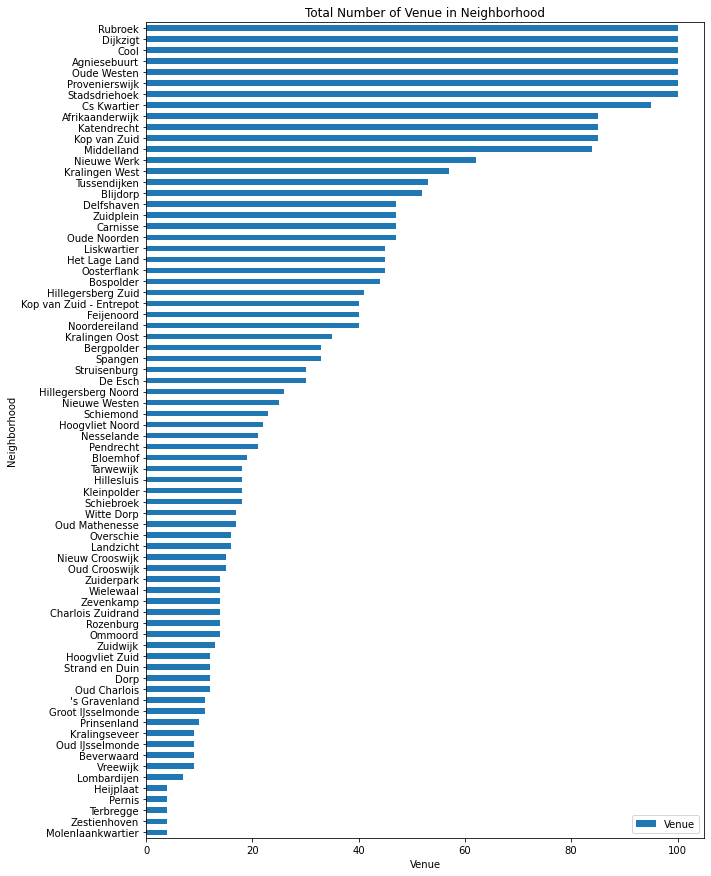

In [10]:
# check how many venues were returned for each neighborhood
rtm_venues_bar = rtm_venues.groupby('Neighborhood').count()

rtm_venues_bar_select = rtm_venues_bar[['Venue']]
sort = rtm_venues_bar_select.sort_values(by='Venue')

# step 2: plot data in bar chart
sort.plot(kind='barh', figsize=(10, 15))

plt.ylabel('Neighborhood') 
plt.xlabel('Venue')
plt.title('Total Number of Venue in Neighborhood') # add title to the plot

plt.show()


The above bar chart shows that some of the neighborhoods such as Oude Westen, CS kwartier and Stadsdriehoek reached the 100 limit of venues, while on the other hand Overschie, 's Gravenland and Vreewijk have lower than 20 venues in the given geospatial coordinates.

The result may reflect all the possible venues in the neighborhoods captured by Foursquare. The results, oboviously, heavily depends on the information given by the Foursquare users including its geospatial coordinates of latitude and longitude. In this case, for given latitude and longitude of a neighborhood, the system will try to find venues within 750m-vicinity of the neighborhood. Depending on the distance between neighborhoods, one venue may be included in more neighborhoods. We can increase the possibilities with neighborhood informations with more Latitude and Longitude informations

In [11]:
# one hot encoding
rtm_onehot = pd.get_dummies(rtm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
rtm_onehot['Neighborhood'] = rtm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [rtm_onehot.columns[-1]] + list(rtm_onehot.columns[:-1])
rtm_onehot = rtm_onehot[fixed_columns]

rtm_onehot.head()

rtm_grouped = rtm_onehot.groupby('Neighborhood').mean().reset_index()
rtm_grouped


,Neighborhood,African Restaurant,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Bougatsa Shop,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Bus Station,Bus Stop,Butcher,Cable Car,Café,Camera Store,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Drugstore,Dutch Restaurant,Electronics Store,Event Space,Exhibit,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hockey Field,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Karaoke Bar,Kebab Restaurant,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Lawyer,Light Rail Station,Lighting Store,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Pier,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Strip Club,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train,Train Station,Tram Station,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Volleyball Court,Water Park,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,'s Gravenland,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.090909,0.00,0.000000,0.090909,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.090909,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0

In [12]:
num_top_venues = 5

for hood in rtm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = rtm_grouped[rtm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----'s Gravenland----
         venue  freq
0  Bus Station  0.09
1  Flower Shop  0.09
2  Supermarket  0.09
3          Gym  0.09
4    Bookstore  0.09


----Afrikaanderwijk----
                 venue  freq
0   Italian Restaurant  0.05
1                Hotel  0.05
2          Coffee Shop  0.05
3  Japanese Restaurant  0.04
4              Theater  0.04


----Agniesebuurt----
                  venue  freq
0           Coffee Shop  0.06
1     French Restaurant  0.04
2                  Café  0.04
3  Fast Food Restaurant  0.04
4    Italian Restaurant  0.04


----Bergpolder----
                       venue  freq
0       Fast Food Restaurant  0.09
1                Supermarket  0.09
2         Italian Restaurant  0.06
3  Latin American Restaurant  0.03
4             Breakfast Spot  0.03


----Beverwaard----
         venue  freq
0     Bus Stop  0.22
1   Restaurant  0.11
2  Snack Place  0.11
3          Bar  0.11
4     Gym Pool  0.11


----Blijdorp----
         venue  freq
0  Zoo Exhibit  0.35
1   Restau

In [13]:
# let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [14]:
#Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = rtm_grouped['Neighborhood']

for ind in np.arange(rtm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(rtm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,'s Gravenland,Shopping Mall,Metro Station,Gym,Bus Station,Flower Shop,Pharmacy,Bistro,Convenience Store,Supermarket,Smoke Shop
1,Afrikaanderwijk,Hotel,Coffee Shop,Italian Restaurant,Theater,French Restaurant,Restaurant,Supermarket,Bistro,Café,Japanese Restaurant
2,Agniesebuurt,Coffee Shop,French Restaurant,Café,Italian Restaurant,Fast Food Restaurant,Bakery,Drugstore,Nightclub,Bar,Hotel
3,Bergpolder,Supermarket,Fast Food Restaurant,Italian Restaurant,Deli / Bodega,Pool,Food & Drink Shop,Shopping Mall,Cheese Shop,Chinese Restaurant,Sports Bar
4,Beverwaard,Bus Stop,Sporting Goods Shop,Park,Bar,Gym,Snack Place,Gym Pool,Restaurant,Zoo Exhibit,Food & Drink Shop


### Cluster Neighborhoods

In [15]:
!conda install -c districtdatalabs yellowbrick --yes

Solving environment: done

# All requested packages already installed.



In [16]:
# set number of clusters
kclusters = 5

rtm_grouped_clustering = rtm_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=5).fit(rtm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 1, 4, 3, 4, 4, 1, 1, 1], dtype=int32)

In [17]:
#Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

# add clustering labels

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

rtm_merged = df_rtm_select

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
rtm_merged = rtm_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

rtm_merged # check the last columns!

,Neighborhood,Postal Code,Population Density per km2,Average House Price in K€,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stadsdriehoek,3011,12065,275,51.917657,4.488733,1.0,Italian Restaurant,Coffee Shop,Bar,Café,Hotel,Sandwich Place,Restaurant,Seafood Restaurant,Ice Cream Shop,French Restaurant
1,Cool,3012,9404,233,51.917812,4.475448,1.0,Bar,Hotel,Ice Cream Shop,Coffee Shop,Burger Joint,Bakery,Sandwich Place,Café,Plaza,Vegetarian / Vegan Restaurant
2,Cs Kwartier,3013,2511,264,51.924428,4.469980,1.0,Hotel,Café,Supermarket,Middle Eastern Restaurant,Restaurant,Bar,Pizza Place,French Restaurant,Plaza,Tram Station
3,Oude Westen,3014,16682,188,51.918257,4.468022,1.0,Bar,Hotel,Sandwich Place,Breakfast Spot,Plaza,Gastropub,Burger Joint,Hostel,Coffee Shop,Museum
4,Dijkzigt,3015,1382,162,51.912476,4.467651,1.0,Bar,Hotel,Coffee Shop,Burger Joint,Chinese Restaurant,Sandwich Place,Restaurant,Café,Art Museum,Record Shop
5,Nieuwe Werk,3016,2552,426,51.906831,4.473120,1.0,Restaurant,Boat or Ferry,French Restaurant,Hotel,Coffee Shop,Café,Steakhouse,Snack Place,History Museum,Mediterranean Restaurant
6,Middelland,3021,17602,213,51.916482,4.459056,1.0,Bar,Indian Restaurant,Hotel,Asian Restaurant,Turkish Restaurant,Coffee Shop,Breakfast Spot,Chinese Restaurant,Deli / Bodega,Caribbean Restaurant
7,Nieuwe Westen,3022,15757,191,51.919712,4.446617,1.0,Indian Restaurant,Plaza,Café,Tram Station,Zoo Exhibit,Drugstore,Playground,Motel,Baseball Field,Deli / Bodega
8,Delfshaven,3024,16407,145,51.905485,4.456437,1.0,Restaurant,Boat or Ferry,Hotel,Café,French Restaurant,Pub,Coffee Shop,Pool Hall,Bistro,Supermarket
9,Bospolder,3025,20895,144,51.908914,4.441043,1.0,Fast Food Restaurant,Restaurant,Tram Station,Harbor / Marina,Furniture / Home Store,Pub,Bar,Supermarket,Brewery,Mediterranean Restaurant


In [18]:
rtm_clean = rtm_merged.dropna(axis = 0, how ='any') 

In [19]:
rtm_clean = rtm_clean.astype({"Cluster Labels": int})

In [20]:
rtm_clean

,Neighborhood,Postal Code,Population Density per km2,Average House Price in K€,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Stadsdriehoek,3011,12065,275,51.917657,4.488733,1,Italian Restaurant,Coffee Shop,Bar,Café,Hotel,Sandwich Place,Restaurant,Seafood Restaurant,Ice Cream Shop,French Restaurant
1,Cool,3012,9404,233,51.917812,4.475448,1,Bar,Hotel,Ice Cream Shop,Coffee Shop,Burger Joint,Bakery,Sandwich Place,Café,Plaza,Vegetarian / Vegan Restaurant
2,Cs Kwartier,3013,2511,264,51.924428,4.469980,1,Hotel,Café,Supermarket,Middle Eastern Restaurant,Restaurant,Bar,Pizza Place,French Restaurant,Plaza,Tram Station
3,Oude Westen,3014,16682,188,51.918257,4.468022,1,Bar,Hotel,Sandwich Place,Breakfast Spot,Plaza,Gastropub,Burger Joint,Hostel,Coffee Shop,Museum
4,Dijkzigt,3015,1382,162,51.912476,4.467651,1,Bar,Hotel,Coffee Shop,Burger Joint,Chinese Restaurant,Sandwich Place,Restaurant,Café,Art Museum,Record Shop
5,Nieuwe Werk,3016,2552,426,51.906831,4.473120,1,Restaurant,Boat or Ferry,French Restaurant,Hotel,Coffee Shop,Café,Steakhouse,Snack Place,History Museum,Mediterranean Restaurant
6,Middelland,3021,17602,213,51.916482,4.459056,1,Bar,Indian Restaurant,Hotel,Asian Restaurant,Turkish Restaurant,Coffee Shop,Breakfast Spot,Chinese Restaurant,Deli / Bodega,Caribbean Restaurant
7,Nieuwe Westen,3022,15757,191,51.919712,4.446617,1,Indian Restaurant,Plaza,Café,Tram Station,Zoo Exhibit,Drugstore,Playground,Motel,Baseball Field,Deli / Bodega
8,Delfshaven,3024,16407,145,51.905485,4.456437,1,Restaurant,Boat or Ferry,Hotel,Café,French Restaurant,Pub,Coffee Shop,Pool Hall,Bistro,Supermarket
9,Bospolder,3025,20895,144,51.908914,4.441043,1,Fast Food Restaurant,Restaurant,Tram Station,Harbor / Marina,Furniture / Home Store,Pub,Bar,Supermarket,Brewery,Mediterranean Restaurant


In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(rtm_clean['Latitude'], rtm_clean['Longitude'], rtm_clean['Neighborhood'], rtm_clean['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

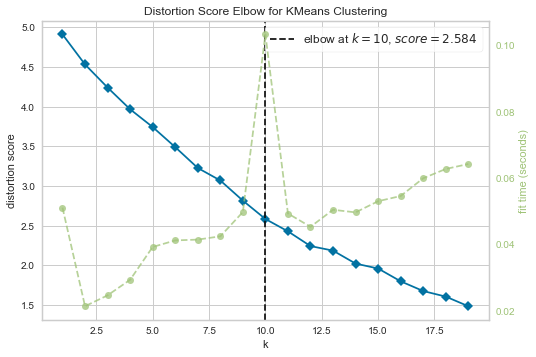

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [72]:
# use kElbowVisualizer to find the best k

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# instantiate the model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))

visualizer.fit(rtm_grouped_clustering) # fit data to visualizer
visualizer.poof() # draw/show/poof the data

In [51]:
rtm_clean.sort_values(by='Average House Price in K€',ascending = False)

,Neighborhood,Postal Code,Population Density per km2,Average House Price in K€,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
42,Kralingen Oost,3062,4058,510,51.928285,4.516245,1,Ice Cream Shop,Park,Breakfast Spot,Gastropub,Restaurant,Supermarket,Bistro,Thai Restaurant,Department Store,Drugstore
38,Molenlaankwartier,3055,4084,495,51.961883,4.506716,4,Forest,Italian Restaurant,Ice Cream Shop,Spa,Food Truck,Food,Food & Drink Shop,Food Court,Food Service,Food Stand
30,Zestienhoven,3045,578,439,51.950672,4.445666,2,Soccer Field,Airport Terminal,Restaurant,Zoo Exhibit,Food Stand,Food,Food & Drink Shop,Food Court,Food Service,Food Truck
5,Nieuwe Werk,3016,2552,426,51.906831,4.473120,1,Restaurant,Boat or Ferry,French Restaurant,Hotel,Coffee Shop,Café,Steakhouse,Snack Place,History Museum,Mediterranean Restaurant
71,Charlois Zuidrand,3084,228,425,51.878659,4.480859,1,Event Space,Dog Run,Athletics & Sports,Soccer Field,Metro Station,Tennis Stadium,Lounge,Park,Restaurant,Concert Hall
37,Hillegersberg Noord,3054,4298,390,51.957236,4.492098,4,Theme Park,Supermarket,French Restaurant,Wine Bar,Bar,Tram Station,Snack Place,Candy Store,Boat or Ferry,Harbor / Marina
47,'s Gravenland,3065,3975,387,51.924023,4.550588,4,Shopping Mall,Metro Station,Gym,Bus Station,Flower Shop,Pharmacy,Bistro,Convenience Store,Supermarket,Smoke Shop
40,Nesselande,3059,4428,366,51.980621,4.584847,4,Shopping Mall,Supermarket,Beach,Clothing Store,Bakery,Spanish Restaurant,Metro Station,Gastropub,Sushi Restaurant,Seafood Restaurant
80,Strand en Duin,3151,596,363,51.981480,4.111910,1,Snack Place,History Museum,French Restaurant,Restaurant,Seafood Restaurant,Diner,Café,Beach,Food Truck,Food Stand
39,Terbregge,3056,1946,338,51.950869,4.506449,1,Monument / Landmark,Train Station,Harbor / Marina,Soccer Field,Zoo Exhibit,Food Service,Flower Shop,Food,Food & Drink Shop,Food Court


In [47]:
rtm_geo = r'rotterdam_new.geojson' # geojson file

# create a plain world map
rtm_map = folium.Map(location=[latitude, longitude], zoom_start=10)

In [48]:
# generate choropleth map 
rtm_map.choropleth(
    geo_data=rtm_geo,
    data=rtm_clean,
    columns=['Neighborhood', 'Average House Price in K€'],
    key_on='feature.properties.buurtnaam',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name = 'Average House Price (k-EUR)',
    reset = True
)

# display map
rtm_map

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 12x12 killometers centered around Berlin city center.

Let's first find the latitude & longitude of Berlin city center, using specific, well known address and geopy geocoder library.

In [ ]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!pip install geocoder
import geocoder

address = 'Station Rotterdam Centraal, Rotterdam'

geolocator = Nominatim(user_agent="rtm_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {}: {}, {}.'.format(address, latitude, longitude))

In [ ]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(api_key, address)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address    = 'Station Rotterdam Centraal, Rotterdam'
rtm_center = [latitude, longitude] #get_coordinates(google_api_key, address)
print('Coordinate of {}: {}'.format(address, rtm_center))

In [ ]:
import pyproj
from pyproj import CRS
from pyproj import Transformer, transform

crs_4326 = CRS("WGS84")
crs_4326

In [ ]:
import numpy as np
transformer = Transformer.from_crs(2263, 4326)
x_coords = np.random.randint(80000, 120000)
y_coords = np.random.randint(200000, 250000)
print(x_coords)

In [ ]:
transform(2263, 4326, x_coords, y_coords)

Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~6km from Alexanderplatz. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [ ]:
#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj
from pyproj import CRS
from pyproj import Transformer, transform

import math

def lonlat_to_xy(lon, lat):
    crs_4326   = CRS(proj='latlong', ellps='WGS84') #proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    crs_proj   = CRS(proj='utm', zone=33, ellps='WGS84') #proj_xy     = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    transformer = Transformer.from_crs(crs_4326, crs_proj)
    xy          = transformer.transform(lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    crs_4326   = CRS(proj='latlong', ellps='WGS84') #proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    crs_proj   = CRS(proj='utm', zone=33, ellps='WGS84') #proj_xy     = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    transformer = Transformer.from_crs(crs_proj, crs_4326)
    lonlat      = transformer.transform(x,y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print('Rotterdam center longitude={}, latitude={}'.format(rtm_center[1], rtm_center[0]))
x, y = lonlat_to_xy(rtm_center[1], rtm_center[0])
print('Rotterdam center UTM X={}, Y={}'.format(x, y))
lo, la = xy_to_lonlat(x, y)
print('Rotterdam center longitude={}, latitude={}'.format(lo, la))

Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [ ]:
rtm_center_x, rtm_center_y = lonlat_to_xy(rtm_center[1], rtm_center[0]) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = rtm_center_x - 6000
x_step = 600
y_min = rtm_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(rtm_center_x, rtm_center_y, x, y)
        if (distance_from_center <= 6001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

Let's visualize the data we have so far: city center location and candidate neighborhood centers:

In [ ]:
#!pip install folium

import folium

In [ ]:
map_rtm = folium.Map(location=rtm_center, zoom_start=13)
folium.Marker(rtm_center, popup='Station Rotterdam Centraal').add_to(map_rtm)
for lat, lon in zip(latitudes, longitudes):
    #folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_rtm)
    #folium.Marker([lat, lon]).add_to(map_berlin)
map_rtm

OK, we now have the coordinates of centers of neighborhoods/areas to be evaluated, equally spaced (distance from every point to it's neighbors is exactly the same) and within ~6km from Alexanderplatz. 

Let's now use Google Maps API to get approximate addresses of those locations.

In [ ]:

def get_address(api_key, latitude, longitude, verbose=False):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&latlng={},{}'.format(api_key, latitude, longitude)
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

addr = get_address(google_api_key, berlin_center[0], berlin_center[1])
print('Reverse geocoding check')
print('-----------------------')
print('Address of [{}, {}] is: {}'.format(berlin_center[0], berlin_center[1], addr))

In [ ]:
print('Obtaining location addresses: ', end='')
addresses = []
for lat, lon in zip(latitudes, longitudes):
    address = get_address(google_api_key, lat, lon)
    if address is None:
        address = 'NO ADDRESS'
    address = address.replace(', Germany', '') # We don't need country part of address
    addresses.append(address)
    print(' .', end='')
print(' done.')

In [ ]:
addresses[150:170]

Looking good. Let's now place all this into a Pandas dataframe.

In [ ]:
import pandas as pd

df_locations = pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})

df_locations.head(10)

...and let's now save/persist this data into local file.

In [ ]:
df_locations.to_pickle('./locations.pkl')    

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name, and we'll make sure to detect and include all the subcategories of specific 'Italian restaurant' category, as we need info on Italian restaurants in the neighborhood.

Foursquare credentials are defined in hidden cell bellow.

In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:
# Category IDs corresponding to Italian restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

italian_restaurant_categories = ['4bf58dd8d48988d110941735','55a5a1ebe4b013909087cbb6','55a5a1ebe4b013909087cb7c',
                                 '55a5a1ebe4b013909087cba7','55a5a1ebe4b013909087cba1','55a5a1ebe4b013909087cba4',
                                 '55a5a1ebe4b013909087cb95','55a5a1ebe4b013909087cb89','55a5a1ebe4b013909087cb9b',
                                 '55a5a1ebe4b013909087cb98','55a5a1ebe4b013909087cbbf','55a5a1ebe4b013909087cb79',
                                 '55a5a1ebe4b013909087cbb0','55a5a1ebe4b013909087cbb3','55a5a1ebe4b013909087cb74',
                                 '55a5a1ebe4b013909087cbaa','55a5a1ebe4b013909087cb83','55a5a1ebe4b013909087cb8c',
                                 '55a5a1ebe4b013909087cb92','55a5a1ebe4b013909087cb8f','55a5a1ebe4b013909087cb86',
                                 '55a5a1ebe4b013909087cbb9','55a5a1ebe4b013909087cb7f','55a5a1ebe4b013909087cbbc',
                                 '55a5a1ebe4b013909087cb9e','55a5a1ebe4b013909087cbc2','55a5a1ebe4b013909087cbad']

def is_restaurant(categories, specific_filter=None):
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    restaurant = False
    specific = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in restaurant_words:
            if r in category_name:
                restaurant = True
        if 'fast food' in category_name:
            restaurant = False
        if not(specific_filter is None) and (category_id in specific_filter):
            specific = True
            restaurant = True
    return restaurant, specific

def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', Deutschland', '')
    address = address.replace(', Germany', '')
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=500, limit=100):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lon, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
    return venues

In [ ]:
# Let's now go over our neighborhood locations and get nearby restaurants; we'll also maintain a dictionary of all found restaurants and all found italian restaurants

import pickle

def get_restaurants(lats, lons):
    restaurants = {}
    italian_restaurants = {}
    location_restaurants = []

    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
        venues = get_venues_near_location(lat, lon, food_category, foursquare_client_id, foursquare_client_secret, radius=350, limit=100)
        area_restaurants = []
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            is_res, is_italian = is_restaurant(venue_categories, specific_filter=italian_restaurant_categories)
            if is_res:
                x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
                restaurant = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_italian, x, y)
                if venue_distance<=300:
                    area_restaurants.append(restaurant)
                restaurants[venue_id] = restaurant
                if is_italian:
                    italian_restaurants[venue_id] = restaurant
        location_restaurants.append(area_restaurants)
        print(' .', end='')
    print(' done.')
    return restaurants, italian_restaurants, location_restaurants

# Try to load from local file system in case we did this before
restaurants = {}
italian_restaurants = {}
location_restaurants = []
loaded = False
try:
    with open('restaurants_350.pkl', 'rb') as f:
        restaurants = pickle.load(f)
    with open('italian_restaurants_350.pkl', 'rb') as f:
        italian_restaurants = pickle.load(f)
    with open('location_restaurants_350.pkl', 'rb') as f:
        location_restaurants = pickle.load(f)
    print('Restaurant data loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    restaurants, italian_restaurants, location_restaurants = get_restaurants(latitudes, longitudes)
    
    # Let's persists this in local file system
    with open('restaurants_350.pkl', 'wb') as f:
        pickle.dump(restaurants, f)
    with open('italian_restaurants_350.pkl', 'wb') as f:
        pickle.dump(italian_restaurants, f)
    with open('location_restaurants_350.pkl', 'wb') as f:
        pickle.dump(location_restaurants, f)
        

In [ ]:
import numpy as np

print('Total number of restaurants:', len(restaurants))
print('Total number of Italian restaurants:', len(italian_restaurants))
print('Percentage of Italian restaurants: {:.2f}%'.format(len(italian_restaurants) / len(restaurants) * 100))
print('Average number of restaurants in neighborhood:', np.array([len(r) for r in location_restaurants]).mean())

In [ ]:
print('List of all restaurants')
print('-----------------------')
for r in list(restaurants.values())[:10]:
    print(r)
print('...')
print('Total:', len(restaurants))

In [ ]:
print('List of Italian restaurants')
print('---------------------------')
for r in list(italian_restaurants.values())[:10]:
    print(r)
print('...')
print('Total:', len(italian_restaurants))

In [ ]:
print('Restaurants around location')
print('---------------------------')
for i in range(100, 110):
    rs = location_restaurants[i][:8]
    names = ', '.join([r[1] for r in rs])
    print('Restaurants around location {}: {}'.format(i+1, names))

Let's now see all the collected restaurants in our area of interest on map, and let's also show Italian restaurants in different color.

In [ ]:
map_berlin = folium.Map(location=berlin_center, zoom_start=13)
folium.Marker(berlin_center, popup='Alexanderplatz').add_to(map_berlin)
for res in restaurants.values():
    lat = res[2]; lon = res[3]
    is_italian = res[6]
    color = 'red' if is_italian else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_berlin)
map_berlin

Looking good. So now we have all the restaurants in area within few kilometers from Alexanderplatz, and we know which ones are Italian restaurants! We also know which restaurants exactly are in vicinity of every neighborhood candidate center.

This concludes the data gathering phase - we're now ready to use this data for analysis to produce the report on optimal locations for a new Italian restaurant!

## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Berlin that have low restaurant density, particularly those with low number of Italian restaurants. We will limit our analysis to area ~6km around city center.

In first step we have collected the required **data: location and type (category) of every restaurant within 6km from Berlin center** (Alexanderplatz). We have also **identified Italian restaurants** (according to Foursquare categorization).

Second step in our analysis will be calculation and exploration of '**restaurant density**' across different areas of Berlin - we will use **heatmaps** to identify a few promising areas close to center with low number of restaurants in general (*and* no Italian restaurants in vicinity) and focus our attention on those areas.

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no more than two restaurants in radius of 250 meters**, and we want locations **without Italian restaurants in radius of 400 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of restaurants in every area candidate**:

In [ ]:
location_restaurants_count = [len(res) for res in location_restaurants]

df_locations['Restaurants in area'] = location_restaurants_count

print('Average number of restaurants in every area with radius=300m:', np.array(location_restaurants_count).mean())

df_locations.head(10)

OK, now let's calculate the **distance to nearest Italian restaurant from every area candidate center** (not only those within 300m - we want distance to closest one, regardless of how distant it is).

In [ ]:
distances_to_italian_restaurant = []

for area_x, area_y in zip(xs, ys):
    min_distance = 10000
    for res in italian_restaurants.values():
        res_x = res[7]
        res_y = res[8]
        d = calc_xy_distance(area_x, area_y, res_x, res_y)
        if d<min_distance:
            min_distance = d
    distances_to_italian_restaurant.append(min_distance)

df_locations['Distance to Italian restaurant'] = distances_to_italian_restaurant

In [ ]:
df_locations.head(10)

In [ ]:
print('Average distance to closest Italian restaurant from each area center:', df_locations['Distance to Italian restaurant'].mean())

OK, so **on average Italian restaurant can be found within ~500m** from every area center candidate. That's fairly close, so we need to filter our areas carefully!

Let's crete a map showing **heatmap / density of restaurants** and try to extract some meaningfull info from that. Also, let's show **borders of Berlin boroughs** on our map and a few circles indicating distance of 1km, 2km and 3km from Alexanderplatz.

In [ ]:
berlin_boroughs_url = 'https://raw.githubusercontent.com/m-hoerz/berlin-shapes/master/berliner-bezirke.geojson'
berlin_boroughs = requests.get(berlin_boroughs_url).json()

def boroughs_style(feature):
    return { 'color': 'blue', 'fill': False }

In [ ]:
restaurant_latlons = [[res[2], res[3]] for res in restaurants.values()]

italian_latlons = [[res[2], res[3]] for res in italian_restaurants.values()]

In [ ]:
from folium import plugins
from folium.plugins import HeatMap

map_berlin = folium.Map(location=berlin_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Looks like a few pockets of low restaurant density closest to city center can be found **south, south-east and east from Alexanderplatz**. 

Let's create another heatmap map showing **heatmap/density of Italian restaurants** only.

In [ ]:
map_berlin = folium.Map(location=berlin_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_berlin) #cartodbpositron cartodbdark_matter
HeatMap(italian_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(berlin_center, radius=1000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=2000, fill=False, color='white').add_to(map_berlin)
folium.Circle(berlin_center, radius=3000, fill=False, color='white').add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

This map is not so 'hot' (Italian restaurants represent a subset of ~15% of all restaurants in Berlin) but it also indicates higher density of existing Italian restaurants directly north and west from Alexanderplatz, with closest pockets of **low Italian restaurant density positioned east, south-east and south from city center**.

Based on this we will now focus our analysis on areas *south-west, south, south-east and east from Berlin center* - we will move the center of our area of interest and reduce it's size to have a radius of **2.5km**. This places our location candidates mostly in boroughs **Kreuzberg and Friedrichshain** (another potentially interesting borough is **Prenzlauer Berg** with large low restaurant density north-east from city center, however this borough is less interesting to stakeholders as it's mostly residental and less popular with tourists).

### Kreuzberg and Friedrichshain

Analysis of popular travel guides and web sites often mention Kreuzberg and Friedrichshain as beautifull, interesting, rich with culture, 'hip' and 'cool' Berlin neighborhoods popular with tourists and loved by Berliners.

*"Bold and brazen, Kreuzberg's creative people, places, and spaces might challenge your paradigm."* Tags: Nightlife, Artsy, Dining, Trendy, Loved by Berliners, Great Transit (airbnb.com)

*"Kreuzberg has long been revered for its diverse cultural life and as a part of Berlin where alternative lifestyles have flourished. Envisioning the glamorous yet gritty nature of Berlin often conjures up scenes from this neighbourhood, where cultures, movements and artistic flare adorn the walls of building and fills the air. Brimming with nightclubs, street food, and art galleries, Kreuzberg is the place to be for Berlin’s young and trendy."* (theculturetrip.com)

*"Imagine an art gallery turned inside out and you’ll begin to envision Friedrichshain. Single walls aren’t canvases for creative works, entire buildings are canvases. This zealously expressive east Berlin neighborhood forgoes social norms"* Tags: Artsy, Nightlife, Trendy, Dining, Touristy, Shopping, Great Transit, Loved by Berliners (airbnb.com)

*"As anyone from Kreuzberg will tell you, this district is not just the coolest in Berlin, but the hippest location in the entire universe. Kreuzberg has long been famed for its diverse cultural life, its experimental alternative lifestyles and the powerful spell it exercises on young people from across Germany. In 2001, Kreuzberg and Friedrichshain were merged to form one administrative borough. When it comes to club culture, Friedrichshain is now out in front – with southern Friedrichshain particularly ranked as home to the highest density of clubs in the city."* (visitberlin.de)

Popular with tourists, alternative and bohemian but booming and trendy, relatively close to city center and well connected, those boroughs appear to justify further analysis.

Let's define new, more narrow region of interest, which will include low-restaurant-count parts of Kreuzberg and Friedrichshain closest to Alexanderplatz.

In [ ]:
roi_x_min = berlin_center_x - 2000
roi_y_max = berlin_center_y + 1000
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_berlin = folium.Map(location=roi_center, zoom_start=14)
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Not bad - this nicely covers all the pockets of low restaurant density in Kreuzberg and Friedrichshain closest to Berlin center.

Let's also create new, more dense grid of location candidates restricted to our new region of interest (let's make our location candidates 100m appart).

In [ ]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

OK. Now let's calculate two most important things for each location candidate: **number of restaurants in vicinity** (we'll use radius of **250 meters**) and **distance to closest Italian restaurant**.

In [ ]:
def count_restaurants_nearby(x, y, restaurants, radius=250):    
    count = 0
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_restaurant(x, y, restaurants):
    d_min = 100000
    for res in restaurants.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_restaurant_counts = []
roi_italian_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_restaurants_nearby(x, y, restaurants, radius=250)
    roi_restaurant_counts.append(count)
    distance = find_nearest_restaurant(x, y, italian_restaurants)
    roi_italian_distances.append(distance)
print('done.')


In [ ]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Restaurants nearby':roi_restaurant_counts,
                                 'Distance to Italian restaurant':roi_italian_distances})

df_roi_locations.head(10)

OK. Let us now **filter** those locations: we're interested only in **locations with no more than two restaurants in radius of 250 meters**, and **no Italian restaurants in radius of 400 meters**.

In [ ]:
good_res_count = np.array((df_roi_locations['Restaurants nearby']<=2))
print('Locations with no more than two restaurants nearby:', good_res_count.sum())

good_ita_distance = np.array(df_roi_locations['Distance to Italian restaurant']>=400)
print('Locations with no Italian restaurants within 400m:', good_ita_distance.sum())

good_locations = np.logical_and(good_res_count, good_ita_distance)
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]


Let's see how this looks on a map.

In [ ]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_berlin)
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.6).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin) 
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Looking good. We now have a bunch of locations fairly close to Alexanderplatz (mostly in Kreuzberg, Friedrichshain and south-east corner of Mitte boroughs), and we know that each of those locations has no more than two restaurants in radius of 250m, and no Italian restaurant closer than 400m. Any of those locations is a potential candidate for a new Italian restaurant, at least based on nearby competition.

Let's now show those good locations in a form of heatmap:

In [ ]:
map_berlin = folium.Map(location=roi_center, zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Looking good. What we have now is a clear indication of zones with low number of restaurants in vicinity, and *no* Italian restaurants at all nearby.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [ ]:
from sklearn.cluster import KMeans

number_of_clusters = 15

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_berlin)
HeatMap(restaurant_latlons).add_to(map_berlin)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_berlin)
folium.Marker(berlin_center).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Not bad - our clusters represent groupings of most of the candidate locations and cluster centers are placed nicely in the middle of the zones 'rich' with location candidates.

Addresses of those cluster centers will be a good starting point for exploring the neighborhoods to find the best possible location based on neighborhood specifics.

Let's see those zones on a city map without heatmap, using shaded areas to indicate our clusters:

In [ ]:
map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.Marker(berlin_center).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Let's zoom in on candidate areas in **Kreuzberg**:

In [ ]:
map_berlin = folium.Map(location=[52.498972, 13.409591], zoom_start=15)
folium.Marker(berlin_center).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

...and candidate areas in **Friedrichshain**:

In [ ]:
map_berlin = folium.Map(location=[52.516347, 13.428403], zoom_start=15)
folium.Marker(berlin_center).add_to(map_berlin)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=False).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_berlin)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_berlin)
folium.GeoJson(berlin_boroughs, style_function=boroughs_style, name='geojson').add_to(map_berlin)
map_berlin

Finaly, let's **reverse geocode those candidate area centers to get the addresses** which can be presented to stakeholders.

In [ ]:
candidate_area_addresses = []
print('==============================================================')
print('Addresses of centers of areas recommended for further analysis')
print('==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(google_api_key, lat, lon).replace(', Germany', '')
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, berlin_center_x, berlin_center_y)
    print('{}{} => {:.1f}km from Alexanderplatz'.format(addr, ' '*(50-len(addr)), d/1000))
    

This concludes our analysis. We have created 15 addresses representing centers of zones containing locations with low number of restaurants and no Italian restaurants nearby, all zones being fairly close to city center (all less than 4km from Alexanderplazt, and about half of those less than 2km from Alexanderplatz). Although zones are shown on map with a radius of ~500 meters (green circles), their shape is actually very irregular and their centers/addresses should be considered only as a starting point for exploring area neighborhoods in search for potential restaurant locations. Most of the zones are located in Kreuzberg and Friedrichshain boroughs, which we have identified as interesting due to being popular with tourists, fairly close to city center and well connected by public transport.

In [ ]:
map_berlin = folium.Map(location=roi_center, zoom_start=14)
folium.Circle(berlin_center, radius=50, color='red', fill=True, fill_color='red', fill_opacity=1).add_to(map_berlin)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_berlin) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_berlin)
map_berlin

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Berlin (~2000 in our initial area of interest which was 12x12km around Alexanderplatz), there are pockets of low restaurant density fairly close to city center. Highest concentration of restaurants was detected north and west from Alexanderplatz, so we focused our attention to areas south, south-east and east, corresponding to boroughs Kreuzberg, Friedrichshain and south-east corner of central Mitte borough. Another borough was identified as potentially interesting (Prenzlauer Berg, north-east from Alexanderplatz), but our attention was focused on Kreuzberg and Friedrichshain which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low restaurant density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Alexanderplatz) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Italian restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all this is 15 zones containing largest number of potential new restaurant locations based on number of and distance to existing venues - both restaurants in general and Italian restaurants particularly. This, of course, does not imply that those zones are actually optimal locations for a new restaurant! Purpose of this analysis was to only provide info on areas close to Berlin center but not crowded with existing restaurants (particularly Italian) - it is entirely possible that there is a very good reason for small number of restaurants in any of those areas, reasons which would make them unsuitable for a new restaurant regardless of lack of competition in the area. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify Berlin areas close to center with low number of restaurants (particularly Italian restaurants) in order to aid stakeholders in narrowing down the search for optimal location for a new Italian restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis (Kreuzberg and Friedrichshain), and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.